# IMPORTS

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import tensorflow as tf
from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import label_binarize
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/ComputerVision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs('Models/ViT', exist_ok=True)

In [3]:
os.makedirs('Models/ViT/Not-Finetuned', exist_ok=True)
os.makedirs('Models/ViT/Finetuned', exist_ok=True)

In [4]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [5]:
class ViTWithHead(nn.Module):
    def __init__(self, pretrained_model, num_classes, dropout_rate=0.4):
        super(ViTWithHead, self).__init__()
        self.vit = pretrained_model  # Base ViT model
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.vit.config.hidden_size),
            nn.Dropout(dropout_rate), 
            nn.Linear(self.vit.config.hidden_size, 256), 
            nn.ReLU(), 
            nn.Dropout(0.3), 
            nn.Linear(256, num_classes)  
        )

    def forward(self, x):
        outputs = self.vit(x) 
        cls_token = outputs.last_hidden_state[:, 0]  # CLS token (first token)
        logits = self.classifier(cls_token) 
        return logits

In [6]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = ViTWithHead(vit_model, num_classes=3)
model.to(device)

ViTWithHead(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, ou

In [7]:
if next(model.parameters()).is_mps:
    print("Model is running on MPS (GPU).")
else:
    print("Model is running on CPU.")

Model is running on MPS (GPU).


# LOADING DATA

In [8]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [9]:
root_dir = 'Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, processor, model, device):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.model = model
        self.device = device 

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        inputs = self.processor(images=image, return_tensors="np").to(self.device)  # Move inputs to device
        inputs = inputs.pixel_values 

        return inputs, label

In [11]:
train_paths = []
train_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(train_dir))}
for class_name in os.listdir(train_dir):
    class_folder = os.path.join(train_dir, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                train_paths.append(os.path.join(class_folder, img_name))
                train_labels.append(class_to_idx[class_name])
print(f"Training images: {len(train_paths)}")

Training images: 3576


In [12]:
val_paths = []
val_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(val_dir))}
for class_name in os.listdir(val_dir):
    class_folder = os.path.join(val_dir, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                val_paths.append(os.path.join(class_folder, img_name))
                val_labels.append(class_to_idx[class_name])
print(f"Validation images: {len(val_paths)}")

Validation images: 1038


In [13]:
test_paths = []
test_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(test_dir))}
for class_name in os.listdir(test_dir):
    class_folder = os.path.join(test_dir, class_name)
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                test_paths.append(os.path.join(class_folder, img_name))
                test_labels.append(class_to_idx[class_name])
print(f"Test images: {len(test_paths)}")

Test images: 536


In [14]:
train_dataset = CustomDataset(train_paths, train_labels, processor, model, device)
val_dataset = CustomDataset(val_paths, val_labels, processor, model, device)
test_dataset = CustomDataset(test_paths, test_labels, processor, model, device)

In [15]:
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
for features, labels in trainLoader:
    features, labels = features.to(device), labels.to(device)
    print(features.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 3, 224, 224])
torch.Size([32])


# TRAINING

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=5):

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for features, labels in train_loader:  
            features, labels = features.to(device), labels.to(device)  
            optimizer.zero_grad()

            # Reshape from [batch_size, 1, 3, 224, 224] to [batch_size, 3, 224, 224]
            features = features.squeeze(1)

            # Forward pass (directly pass the features into the classifier)
            outputs = model(features)
            logits = outputs 

            if len(labels.shape) > 1:  # If labels are one-hot encoded
                labels = labels.argmax(dim=1)  # Convert to class indices

            # Compute the loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)  # Get predicted class indices
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Validation Loop
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for features, labels in val_loader: 
                features, labels = features.to(device), labels.to(device)

                # Reshape features from [batch_size, 1, 3, 224, 224] to [batch_size, 3, 224, 224]
                features = features.squeeze(1)

                outputs = model(features)  # Pass features to the model
                logits = outputs  
                
                if len(labels.shape) > 1:
                    labels = labels.argmax(dim=1)

                # Compute the validation loss
                loss = criterion(logits, labels)
                val_loss += loss.item()

                _, predicted = logits.max(1)  # Get predicted class indices
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Compute epoch-wise losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Update LR Scheduler
        scheduler.step(avg_val_loss)

        for param_group in optimizer.param_groups:
            print(f"Epoch [{epoch+1}/{num_epochs}] - LR: {param_group['lr']:.6f}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "Models/ViT/best_vit_model.pth")  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
for param in model.vit.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8)

Epoch [1/250] - Train Loss: 0.7902, Train Acc: 0.6415 - Val Loss: 0.8312, Val Acc: 0.6195
Epoch [1/250] - LR: 0.001000
Epoch [2/250] - Train Loss: 0.6902, Train Acc: 0.6871 - Val Loss: 0.8411, Val Acc: 0.6281
Epoch [2/250] - LR: 0.001000
Epoch [3/250] - Train Loss: 0.6413, Train Acc: 0.7136 - Val Loss: 0.7442, Val Acc: 0.6850
Epoch [3/250] - LR: 0.001000
Epoch [4/250] - Train Loss: 0.6258, Train Acc: 0.7287 - Val Loss: 0.7318, Val Acc: 0.6850
Epoch [4/250] - LR: 0.001000
Epoch [5/250] - Train Loss: 0.5986, Train Acc: 0.7315 - Val Loss: 0.6775, Val Acc: 0.7254
Epoch [5/250] - LR: 0.001000
Epoch [6/250] - Train Loss: 0.5777, Train Acc: 0.7447 - Val Loss: 0.6841, Val Acc: 0.7110
Epoch [6/250] - LR: 0.001000
Epoch [7/250] - Train Loss: 0.5578, Train Acc: 0.7562 - Val Loss: 0.6955, Val Acc: 0.7235
Epoch [7/250] - LR: 0.001000
Epoch [8/250] - Train Loss: 0.5755, Train Acc: 0.7458 - Val Loss: 0.6955, Val Acc: 0.7062
Epoch [8/250] - LR: 0.001000
Epoch [9/250] - Train Loss: 0.5430, Train Acc: 0

In [ ]:
# torch.save(model, "Models/ViT/Not-Finetuned/ViT-Base16-in21k.pth")
# torch.save(model.state_dict(), "Models/ViT/Not-Finetuned/ViT-Base16-in21k_weights.pth")

# FINE-TUNING

In [ ]:
model.load_state_dict(torch.load("Models/ViT/best_vit_model.pth", map_location=device))

for param in model.vit.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-7)
train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune = train_model(
    model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8
)

Epoch [1/250] - Train Loss: 0.4171, Train Acc: 0.8191 - Val Loss: 0.6026, Val Acc: 0.7505
Epoch [1/250] - LR: 0.000001
Epoch [2/250] - Train Loss: 0.3989, Train Acc: 0.8336 - Val Loss: 0.5874, Val Acc: 0.7755
Epoch [2/250] - LR: 0.000001
Epoch [3/250] - Train Loss: 0.3870, Train Acc: 0.8451 - Val Loss: 0.5976, Val Acc: 0.7514
Epoch [3/250] - LR: 0.000001
Epoch [4/250] - Train Loss: 0.3769, Train Acc: 0.8440 - Val Loss: 0.5947, Val Acc: 0.7524
Epoch [4/250] - LR: 0.000001
Epoch [5/250] - Train Loss: 0.3626, Train Acc: 0.8557 - Val Loss: 0.5947, Val Acc: 0.7553
Epoch [5/250] - LR: 0.000001
Epoch [6/250] - Train Loss: 0.3642, Train Acc: 0.8507 - Val Loss: 0.5866, Val Acc: 0.7582
Epoch [6/250] - LR: 0.000001
Epoch [7/250] - Train Loss: 0.3519, Train Acc: 0.8512 - Val Loss: 0.5964, Val Acc: 0.7476
Epoch [7/250] - LR: 0.000001
Epoch [8/250] - Train Loss: 0.3453, Train Acc: 0.8599 - Val Loss: 0.6042, Val Acc: 0.7457
Epoch [8/250] - LR: 0.000001
Epoch [9/250] - Train Loss: 0.3324, Train Acc: 0

In [ ]:
model.load_state_dict(torch.load("Models/ViT/best_vit_model.pth", map_location=device))
# torch.save(model, "Models/ViT/Finetuned/ViT-Base16-in21k.pth")
# torch.save(model.state_dict(), "Models/ViT/Finetuned/ViT-Base16-in21k_weights.pth")

# PLOTS

In [22]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

## Pre-Trained

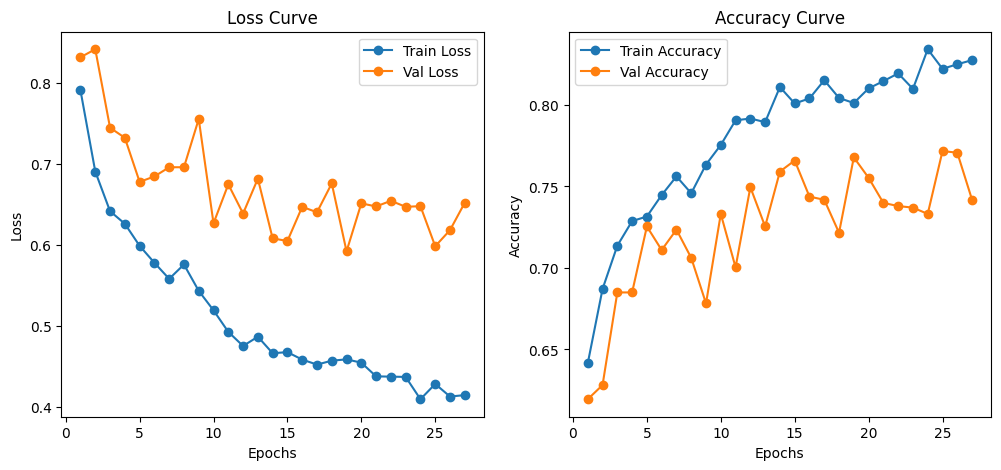

In [23]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Fine-Tuned

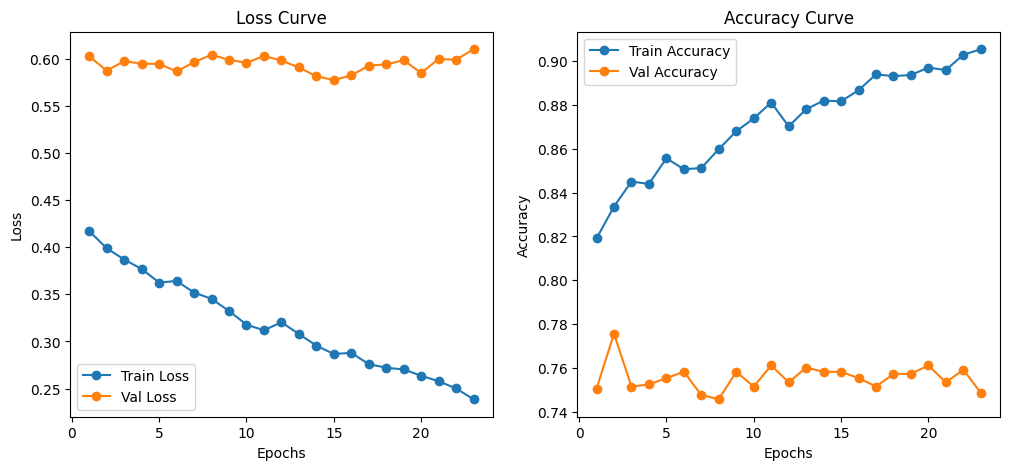

In [24]:
plot_metrics(train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune)

# TESTING

In [25]:
model.load_state_dict(torch.load("Models/ViT/Finetuned/ViT-Base16-in21k_weights.pth", map_location=device))

<All keys matched successfully>

In [26]:
def evaluate_model(model, test_loader, categories):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            images = images.squeeze(1)  # Shape becomes [32, 3, 224, 224]

            outputs = model(images) 
            _, predicted = outputs.max(1)

            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1:
                labels = labels.argmax(dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=categories))
    return all_labels, all_preds

In [27]:
labels, preds = evaluate_model(model, testLoader, categories)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.74      0.73      0.73       179
  Osteopenia       0.82      0.86      0.84       180
Osteoporosis       0.85      0.82      0.84       177

    accuracy                           0.80       536
   macro avg       0.80      0.80      0.80       536
weighted avg       0.80      0.80      0.80       536



# PR CURVE

In [28]:
def find_best_thresholds(model, test_loader, num_classes):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            labels = labels.cpu().numpy()
            if labels.ndim == 1:
                labels = labels.reshape(-1, 1)  # Shape [batch_size, 1]

            images = images.squeeze(1)  # Shape becomes [batch, 3, 224, 224]

            # Get model output logits
            outputs = model(images) 

            # Convert logits to probabilities
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Softmax for multi-class classification

            all_probs.append(probs)
            all_labels.append(labels)

    all_probs = np.concatenate(all_probs, axis=0)  # Shape: [n_samples, n_classes]
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: [n_samples, 1] 

    # One-hot encode labels (needed for multi-class precision-recall curve)
    all_labels = label_binarize(all_labels, classes=np.arange(num_classes))  # Shape: [n_samples, n_classes]

    best_thresholds = []

    for class_idx in range(num_classes):
        binary_labels = all_labels[:, class_idx]  # Get class labels (binary format)

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(binary_labels, all_probs[:, class_idx])

        # Compute F1 scores for each threshold
        f1_scores = (2 * precision * recall) / (precision + recall + np.finfo(float).eps)  # Avoid division by zero

        # Get threshold with max F1 score
        best_threshold = thresholds[np.argmax(f1_scores)] if thresholds.size > 0 else 0.5
        best_thresholds.append(best_threshold)

        print(f"Best threshold for class {class_idx}: {best_threshold:.4f}")

    return best_thresholds


best_thresholds = find_best_thresholds(model, testLoader, 3)
best_thresholds

Best threshold for class 0: 0.3983
Best threshold for class 1: 0.6438
Best threshold for class 2: 0.1324


[0.39828026, 0.6437636, 0.13236469]

In [29]:
def evaluate_with_best_thresholds(model, test_loader, best_thresholds, categories):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()

            if len(images.shape) == 5:
                images = images.squeeze(1)  # Remove the extra dimension, if necessary

            # Ensure labels are in a multi-label format (one-hot encoded)
            if labels.ndim == 1: 
                labels = np.eye(len(categories))[labels]

            outputs = model(images)
            if isinstance(outputs, tuple):  
                outputs = outputs[0]

            # Apply sigmoid activation
            probs = torch.sigmoid(outputs).cpu().numpy()

            # Apply best thresholds for each class
            preds = (probs > np.array(best_thresholds)).astype(int)
            preds = np.argmax(preds*probs, axis=1)
            preds = label_binarize(preds, classes=np.arange(len(categories)))

            all_preds.extend(preds)
            all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Ensure both are in the same shape and format
    if all_labels.shape != all_preds.shape:
        raise ValueError(f"Shape mismatch: labels {all_labels.shape}, preds {all_preds.shape}")

    # Print Classification Report
    print("Classification Report with Optimized Thresholds:\n",
          classification_report(all_labels, all_preds, target_names=categories))
    
    return all_labels, all_preds

In [30]:
labels, preds = evaluate_with_best_thresholds(model, testLoader, best_thresholds, categories)

Classification Report with Optimized Thresholds:
               precision    recall  f1-score   support

      Normal       0.72      0.73      0.72       179
  Osteopenia       0.83      0.82      0.82       180
Osteoporosis       0.83      0.83      0.83       177

   micro avg       0.79      0.79      0.79       536
   macro avg       0.79      0.79      0.79       536
weighted avg       0.79      0.79      0.79       536
 samples avg       0.79      0.79      0.79       536



Text(95.72222222222221, 0.5, 'True Label')

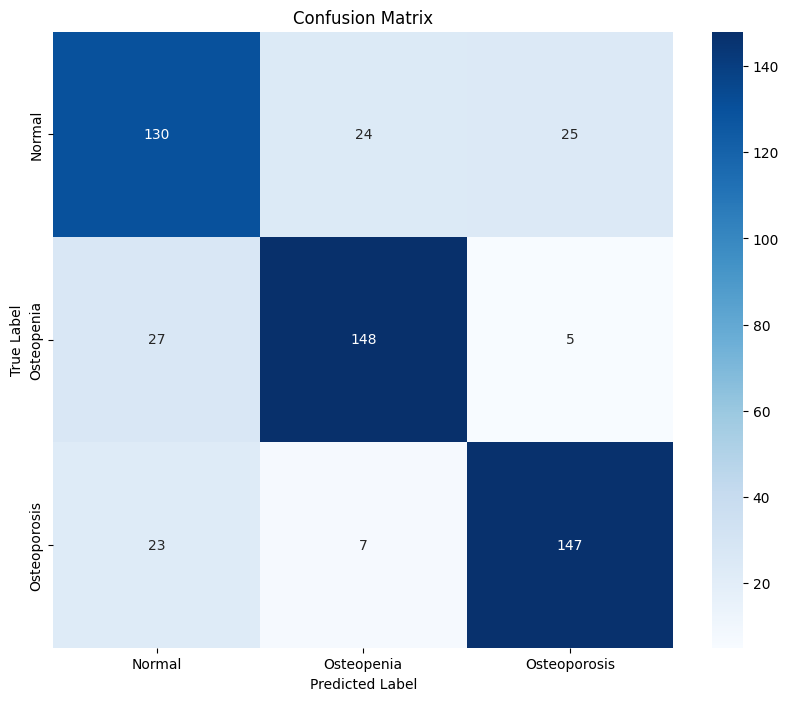

In [34]:
conf_matrix = confusion_matrix(np.argmax(labels, axis=1), np.argmax(preds, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')